### LSE Data Analytics Online Career Accelerator

# DA201: Data Analytics using Python

# Time-series forecasting (tutorial video)

This Jupyter Notebook is based on the time-series forecasting with Python tutorial video. Watch the video to explore time series forecasting with the simple moving average method in Python. In the video, you will explore:

- what a simple moving average is
- how to calculate a simple moving average
- how to calculate a simple moving average data set.

## Prepare your workstation

In [1]:
# Import necessary libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Get multiple outputs in the same cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Simple hacks to make plots look better: 
# # Colour palette to make charts look better.
blue, = sns.color_palette("muted", 1) 

# Dark grid, white grid, dark, white, and ticks.
sns.set_style('whitegrid') 

# Font size of the axes titles.
plt.rc('axes', titlesize=18) 

# Font size of the x and y labels.
plt.rc('axes', labelsize=14)    

# Font size of the tick labels.
plt.rc('xtick', labelsize=13,color='#4f4e4e') 

# Font size of the tick labels.
plt.rc('ytick', labelsize=13,color='#4f4e4e')  

# Font size of the Legend.
plt.rc('legend', fontsize=13)

# Default text size.
plt.rc('font', size=13)          

In [3]:
# Import CSV file with Pandas.
data = pd.read_csv('raw_sales.csv', index_col=['datesold'], parse_dates=['datesold'])

# View DataFrame.
print(data.shape)
data.head()

(29580, 4)


,postcode,price,propertyType,bedrooms
datesold,,,,
2007-02-07,2607,525000,house,4
2007-02-27,2906,290000,house,3
2007-03-07,2905,328000,house,3
2007-03-09,2905,380000,house,4
2007-03-21,2906,310000,house,3


In [4]:
# Creating a copy of the original data for convenience: 
data_sub = data.copy()

# Data set consisting of houses with 5 bedrooms: 
df_5 = data_sub[data_sub['bedrooms'] == 5]

# View output.
df_5.head

<bound method NDFrame.head of             postcode    price propertyType  bedrooms
datesold                                            
2007-07-02      2914   800000        house         5
2007-07-06      2615   535000        house         5
2007-08-07      2904   815000        house         5
2007-08-21      2902   418000        house         5
2007-09-21      2603  1460000        house         5
...              ...      ...          ...       ...
2019-07-23      2905   700000        house         5
2019-07-27      2905   865000        house         5
2014-05-31      2603  1490000         unit         5
2014-07-31      2617   729000         unit         5
2014-11-01      2605  1220000         unit         5

[1950 rows x 4 columns]>

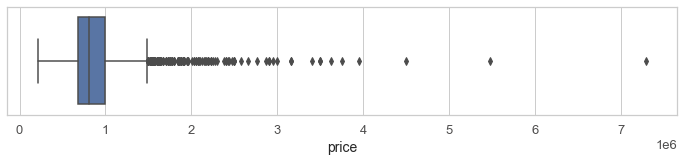

In [5]:
# Determine outliers for 5 bedrooms.
# whis = multiplicative factor
import seaborn as sns

fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=df_5['price'], whis=1.5);

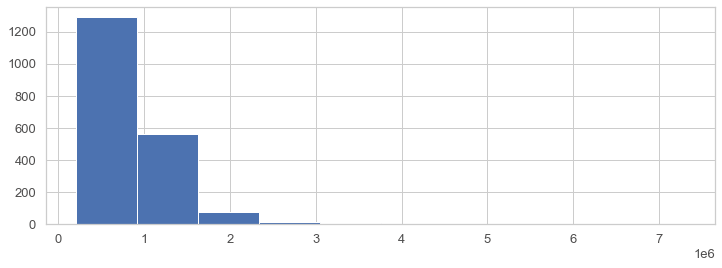

In [6]:
# Histogram of data set (5 bedrooms only).
fig = df_5.price.hist(figsize = (12, 4))

In [7]:
# Outlier removal:
# Removing outliers from data set with 2 bedrooms:
# The columns you want to search for outliers in.
cols = ['price'] 

# Calculate quantiles and IQR.
# Same as np.percentile but maps (0,1) and not (0,100).
Q1 = df_5[cols].quantile(0.25) 
Q3 = df_5[cols].quantile(0.75)
IQR = Q3 - Q1
IQR

# # Return a boolean array of the rows with (any) non-outlier column values.
condition = ~((df_5[cols] < (Q1 - 1.5 * IQR)) | (df_5[cols] > (Q3 + 1.5 * IQR))).any(axis=1)

# Filter the DataFrame based on a condition.
df_5_non_outlier = df_5[condition]
df_5_non_outlier.shape

price    325000.0
dtype: float64

(1809, 4)

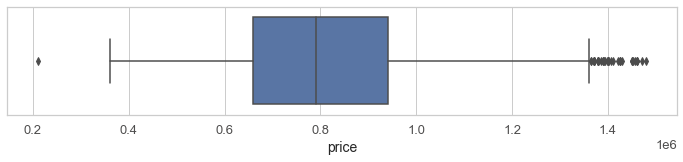

In [8]:
# Plot to see if outliers have been removed: 
# whis = multiplicative factor
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=df_5_non_outlier['price'], whis=1.5);

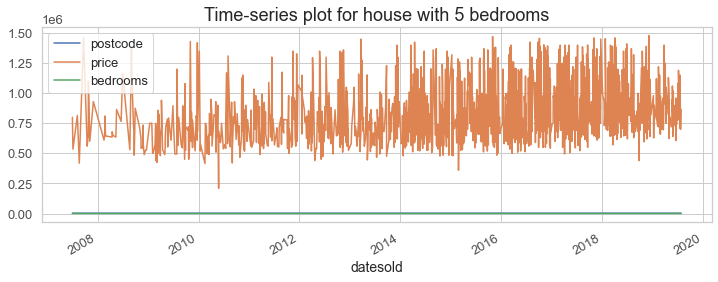

In [9]:
# Plotting the time-series data.
df_5_non_outlier.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Time-series plot for house with 5 bedrooms")
plt.show(block=False);

In [10]:
# Resampling data set with 5 bedrooms: 
df_5_res = df_5_non_outlier.resample('M').mean()

# View the DataFrame.
df_5_res.head()

,postcode,price,bedrooms
datesold,,,
2007-07-31,2764.500000,6.675000e+05,5.0
2007-08-31,2903.000000,6.165000e+05,5.0
2007-09-30,2603.000000,1.460000e+06,5.0
2007-10-31,2811.333333,7.683333e+05,5.0
2007-11-30,2611.000000,6.000000e+05,5.0


In [11]:
# Dropping the missing values: 
df_5_res.dropna(inplace= True)

df_5_res.isna().sum()

postcode    0
price       0
bedrooms    0
dtype: int64

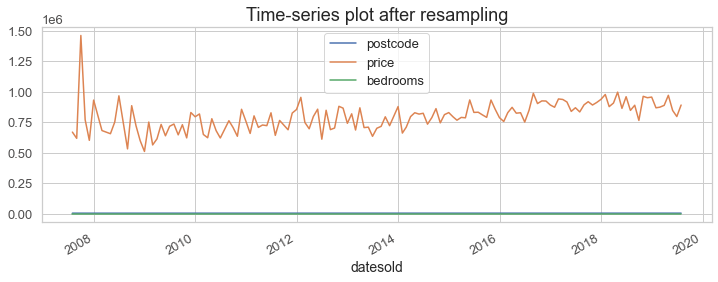

In [12]:
# Plotting the time-series data.
df_5_res.plot(figsize=(12, 4))
plt.legend(loc='best')
plt.title("Time-series plot after resampling")
plt.show(block=False);

# 

## Calculate the Simple Moving Average (SMA) for houses with 5 bedrooms

In [13]:
# This is a function to calculate and plot the simple moving average: 
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(12,4))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, 'g', label='Simple moving average trend')
    
    # Plot confidence intervals for smoothed values.
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc='best')
    plt.grid(True)

In [14]:
# Calculate SMA for a window size of 5.
df_5_res['SMA_5'] = df_5_res.iloc[:, 1].rolling(window=5).mean()

# Print the first 15 rows of data.
print(df_5_res.head(15))

               postcode         price  bedrooms          SMA_5
datesold                                                      
2007-07-31  2764.500000  6.675000e+05       5.0            NaN
2007-08-31  2903.000000  6.165000e+05       5.0            NaN
2007-09-30  2603.000000  1.460000e+06       5.0            NaN
2007-10-31  2811.333333  7.683333e+05       5.0            NaN
2007-11-30  2611.000000  6.000000e+05       5.0  822466.666667
2007-12-31  2615.000000  9.300000e+05       5.0  874966.666667
2008-02-29  2683.000000  6.802500e+05       5.0  887716.666667
2008-04-30  2907.666667  6.543333e+05       5.0  726583.333333
2008-05-31  2754.000000  7.500000e+05       5.0  722916.666667
2008-06-30  2603.500000  9.650000e+05       5.0  795916.666667
2008-08-31  2905.000000  5.300000e+05       5.0  715916.666667
2008-09-30  2808.166667  8.841667e+05       5.0  756700.000000
2008-10-31  2605.000000  7.200000e+05       5.0  769833.333333
2008-11-30  2657.666667  5.976167e+05       5.0  739356

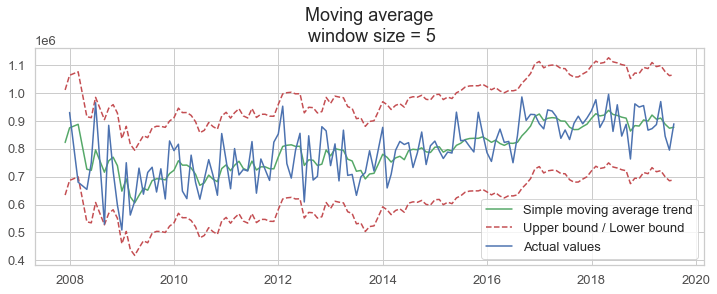

In [15]:
# Smooth by the previous 5 days.
plot_moving_average(df_5_res.price, 5, plot_intervals=True)

In [16]:
# Calculate SMA for a window size of 5.
df_5_res['SMA_30'] = df_5_res.iloc[:, 1].rolling(window=30).mean()

# Calculate SMA for a window size of 5.
df_5_res['SMA_90'] = df_5_res.iloc[:, 1].rolling(window=90).mean()

# Print the first 100 rows of data.
print(df_5_res.head(100))

               postcode         price  bedrooms          SMA_5         SMA_30  \
datesold                                                                        
2007-07-31  2764.500000  6.675000e+05       5.0            NaN            NaN   
2007-08-31  2903.000000  6.165000e+05       5.0            NaN            NaN   
2007-09-30  2603.000000  1.460000e+06       5.0            NaN            NaN   
2007-10-31  2811.333333  7.683333e+05       5.0            NaN            NaN   
2007-11-30  2611.000000  6.000000e+05       5.0  822466.666667            NaN   
...                 ...           ...       ...            ...            ...   
2015-09-30  2753.619048  7.885000e+05       5.0  837535.337391  778383.545336   
2015-10-31  2781.178571  9.308255e+05       5.0  837440.437391  785925.347717   
2015-11-30  2766.625000  8.554766e+05       5.0  842735.749891  790838.455356   
2015-12-31  2700.230769  7.859908e+05       5.0  833823.783737  795938.147664   
2016-01-31  2826.727273  7.5

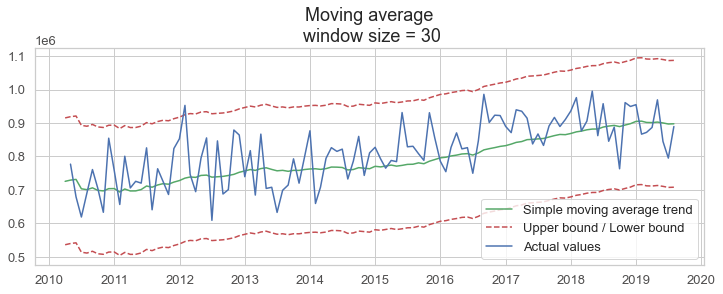

In [17]:
# Smooth by the previous month (30 days).
plot_moving_average(df_5_res.price, 30, plot_intervals=True)

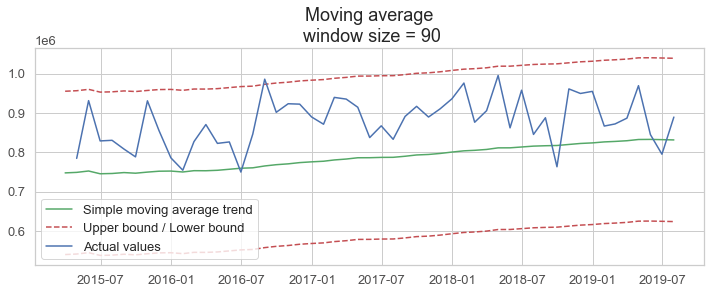

In [18]:
# Smooth by the previous quarter (90 days).
plot_moving_average(df_5_res.price, 90, plot_intervals=True)